# Weighted non-linear regression with Arrhenius model illustration

Non-linear regression with varying uncertainties in samples.

Let's consider the familiar example of the Arrhenius model again.

NEW CASE:
---------
Say, for instance, we know that, at T > 550 C, the uncertainty
 in the rate constants doubles.

How can we adequately model this data? For the linear case, there is
weighted linear regression, but for the non-linear case, we can use
the weighted non-linear regression as illustrated below.

In [1]:
#%%
# Import necessary libraries.
from ml_uncertainty.non_linear_regression import NonLinearRegression
from ml_uncertainty.model_inference import ParametricModelInference
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Let's say have some experimental data for a rate constant study.
# Let's say we wish to fit an Arrhenius model to it.
# Let's say we use the data provided in the link below to study
# the rate of reaction for conversion of cyclopropane to propene.
# Source: https://chem.libretexts.org/Bookshelves/
# Physical_and_Theoretical_Chemistry_Textbook_Maps/
# Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/
# Kinetics/06%3A_Modeling_Reaction_Kinetics/
# 6.02%3A_Temperature_Dependence_of_Reaction_Rates/6.2.03%3A_The_Arrhenius_Law/
# 6.2.3.01%3A_Arrhenius_Equation


def arrhenius_model(T, coefs_):
    r"""Arrhenius model function for rate of reaction prediction.

    $$ k = Ae^{-Ea/RT}$$

    Source: See source above

    Parameters:
    -----------
    T: np.ndarray of dimension 1
        Temperatures in $\degree C$
    coefs_: np.ndarray of shape (2,)
        Denotes [A, Ea].
        A (units: same as those of rate constant k),
        Ea (units: J/mol).

    Returns:
    --------
    np.ndarray of dimension 1.
        Corresponding to k values for each T value.
    """

    X = T[:, 0] + 273  # transforming to K
    R = 8.314  # J/mol/K
    A, Ea = coefs_
    k = A * np.exp(-Ea / (R * X))
    k = k.reshape((-1,))
    return k


# The data provided is as follows: ($\degree C$)
T_expt = np.array([477, 523, 577, 623])

# For these values, the experimental k values are as follows: (1/s)
k_expt = np.array([0.0018, 0.0027, 0.030, 0.26])

# They have reported best fit parameters which they obtained.
# Calculated linearizing the Arrhenius model and fitting it to data.
# This might not be the best approach, but for this example, we consider it the
# ground truth.
# Ea: provided, A: calculated accordingly.
# A: 1/s, Ea: J/mol
true_params = np.array([1.39406453358858e15, 271.867e3])

# Let's say the uncertainties in the rate constants were as discussed above.
k_se = np.array([0.05, 0.05, 0.1, 0.1])


   experimental    nlr_fitted       nlr_std  lower_bound_90%_conf  \
A  1.394065e+15  2.171999e+06  5.511185e+06         -1.392058e+07   
E  2.718670e+05  1.197440e+05  1.862949e+04          6.534614e+04   

   upper_bound_90%_conf  
A          1.826458e+07  
E          1.741418e+05  


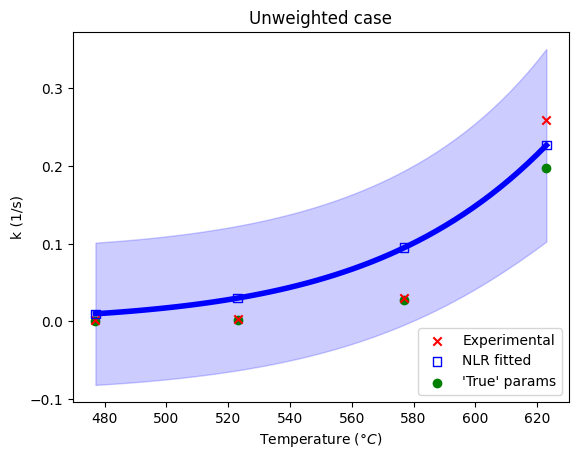

In [2]:
#%%
# ================================================
# UNWEIGHTED CASE
# ------------------
# Let's say we did not account for this and simply fit the model.
# This would be just like the non_linea_regression_arrhenius.py example.
nlr = NonLinearRegression(model=arrhenius_model, p0_length=2)
T_expt_mat = T_expt.reshape((-1, 1))
nlr.fit(T_expt_mat, k_expt)
k_pred = nlr.predict(T_expt_mat)
k_true_pred = nlr.predict(T_expt_mat, params=true_params)

# Compare known parameters with fitted parameters.
df_param = pd.DataFrame(index=["A", "E"])
df_param["experimental"] = true_params
df_param["nlr_fitted"] = nlr.coef_

# Model inference
inf = ParametricModelInference()
inf.set_up_model_inference(X_train=T_expt_mat, y_train=k_expt, estimator=nlr)
df_feature_imp = inf.get_parameter_errors()

# Compute confidence intervals for new T values.
T_new = np.linspace(T_expt.min(), T_expt.max(), 50).reshape((-1, 1))
k_new = nlr.predict(T_new)
df_int = inf.get_intervals(T_new)
# Look at the parameter errors for these.
df_param["nlr_fitted"] = df_feature_imp["mean"].values
df_param["nlr_std"] = df_feature_imp["std"].values
df_param["lower_bound_90%_conf"] = df_feature_imp["lower_bound"].values
df_param["upper_bound_90%_conf"] = df_feature_imp["upper_bound"].values

print(df_param)

# Plot the prediction intervals.
plt.figure()
plt.xlabel(r"Temperature ($\degree C$)")
plt.ylabel(r"k (1/s)")
plt.title("Unweighted case")

# Showing experimental points and predicted points.
plt.scatter(T_expt, k_expt, marker="x", color="red", zorder=1, label="Experimental")
plt.scatter(
    T_expt,
    k_pred,
    marker="s",
    edgecolor="blue",
    facecolor="none",
    zorder=1,
    label="NLR fitted",
)
plt.scatter(
    T_expt, k_true_pred, marker="o", color="green", zorder=0.7, label="'True' params"
)

plt.plot(T_new[:, 0], df_int["mean"], lw=4, color="blue", zorder=0.5)

plt.fill_between(
    T_new[:, 0],
    df_int["lower_bound"],
    df_int["upper_bound"],
    color="blue",
    alpha=0.2,
    zorder=0,
)

plt.legend(loc="lower right")


   experimental    nlr_fitted       nlr_std  lower_bound_90%_conf  \
A  1.394065e+15  2.132406e+14  1.356976e+14         -1.829944e+14   
E  2.718670e+05  2.558766e+05  4.737019e+03          2.420446e+05   

   upper_bound_90%_conf  
A          6.094756e+14  
E          2.697086e+05  


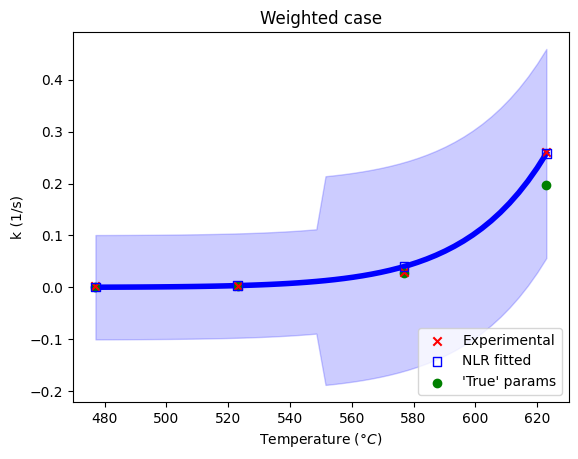

In [3]:
#%%
# ================================================
# WEIGHTED CASE

nlr = NonLinearRegression(model=arrhenius_model, p0_length=2)
T_expt_mat = T_expt.reshape((-1, 1))

# It is common practice to set the weights as inverse of the square
# of the parameter uncertainty.
w = 1 / k_se ** 2

# Fit using the weights.
nlr.fit(T_expt_mat, k_expt, sample_weight=w)

k_pred = nlr.predict(T_expt_mat)
k_true_pred = nlr.predict(T_expt_mat, params=true_params)

# Compare known parameters with fitted parameters.
df_param = pd.DataFrame(index=["A", "E"])
df_param["experimental"] = true_params
df_param["nlr_fitted"] = nlr.coef_

# Model inference
inf = ParametricModelInference()

# IMPORTANT! Make sure to pass the weights here.
inf.set_up_model_inference(
    X_train=T_expt_mat, y_train=k_expt, estimator=nlr, y_train_weights=w
)

df_feature_imp = inf.get_parameter_errors()

# Compute confidence intervals for new T values.
T_new = np.linspace(T_expt.min(), T_expt.max(), 50).reshape((-1, 1))
k_new = nlr.predict(T_new)

# Also create the weights here so that the
# appropriate uncertainties are considered.
k_se_new = np.zeros((T_new.shape[0],))
# Add the correct uncertainties to this array.
k_se_new[T_new[:, 0] < 550] = 1
k_se_new[T_new[:, 0] > 550] = 2

w_new = 1 / k_se_new ** 2
w_new = w_new / w_new.mean()

# Add the corresponding y weights
df_int = inf.get_intervals(T_new, y_weights=w_new)

# Look at the parameter errors for these.
df_param["nlr_fitted"] = df_feature_imp["mean"].values
df_param["nlr_std"] = df_feature_imp["std"].values
df_param["lower_bound_90%_conf"] = df_feature_imp["lower_bound"].values
df_param["upper_bound_90%_conf"] = df_feature_imp["upper_bound"].values

print(df_param)


# Plot the prediction intervals.
plt.figure()
plt.xlabel(r"Temperature ($\degree C$)")
plt.ylabel(r"k (1/s)")
plt.title("Weighted case")

# Showing experimental points and predicted points.
plt.scatter(T_expt, k_expt, marker="x", color="red", zorder=1, label="Experimental")
plt.scatter(
    T_expt,
    k_pred,
    marker="s",
    edgecolor="blue",
    facecolor="none",
    zorder=1,
    label="NLR fitted",
)
plt.scatter(
    T_expt, k_true_pred, marker="o", color="green", zorder=0.7, label="'True' params"
)

plt.plot(T_new[:, 0], df_int["mean"], lw=4, color="blue", zorder=0.5)

plt.fill_between(
    T_new[:, 0],
    df_int["lower_bound"],
    df_int["upper_bound"],
    color="blue",
    alpha=0.2,
    zorder=0,
)

plt.legend(loc="lower right")


## Conclusions:
1. Notice that the fit has improved to become close to the
higher weighted, i.e., lower uncertainty points.
2. Notice that with the weighted non-linear approach, we
are able to reproduce the uncertainties accurately and predict
higher uncertainties for points where we would expect there to be
higher uncertainties.
